# Quantifying Uncertainty with Markov Chain Monte Carlo Sampling

__Benjamin Pope__

_University of Queensland_ 

<img src="qrcode_mcmc.png" alt="QR Code" style="width: 300px; display:block; margin:auto"/>

In [1]:
# This is going to be an interactive lecture using Jupyter! 
# So let's import things!

import numpy as np 

from astropy.table import Table

import matplotlib.pyplot as plt

import emcee
import chainconsumer
from chainconsumer import ChainConsumer, Chain

# Hubble's Original Data

Here are some distances from Edwin Hubble's [1929 paper](https://www.pnas.org/doi/pdf/10.1073/pnas.15.3.168) discovering the expansion of the universe. 

<img src="hubble.png" alt="Hubble's Data" style="width: 500px;"/>


In this lecture, we're going to learn how to fit a model to data like these - and to quantify their uncertainty.

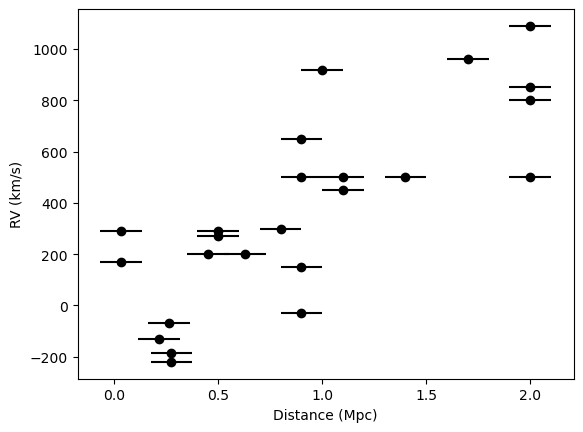

In [2]:
# Load and plot Hubble original data

data = Table.read('../data/hubble.txt', format='ascii')
d, v = data['r'], data['v']
d_err = 0.1
plt.errorbar(d,v,xerr=d_err,fmt='o',color='k')
plt.xlabel('Distance (Mpc)')
plt.ylabel('RV (km/s)');

In physics we gather data through experiment and observation; and do theoretical work to calculate how the outcomes of experiments depend on parameters of their models. 


The job of data analysts in physics is to connect the two, solving the inverse problem to infer parameters of a theory from empirical data - and it is usually just as important to quantify the uncertainty on these parameters as to just find a best fitting model. 


The most common way to do this is with a Markov Chain Monte Carlo algorithm, which gives us a set of samples drawn from this probability distribution. 


In this lecture I will discuss the theory and the surprising history behind the now-ubiquitous MCMC, and illustrate this with an interactive session fitting Hubble's original discovery of the expanding universe with a simple model in Python. 


My favourite review paper on this is [Hogg & Foreman-Mackey, 2017](https://arxiv.org/abs/1710.06068), _Data analysis recipes: Using Markov Chain Monte Carlo_.

# What do we mean by Monte Carlo methods?

## Stan Ulam

<img src="ulam.png" alt="MCMC Paper" style="width: 700px; display:block; margin:auto"/>


## Metropolis-Hastings Algorithm

<img src="mr2t2.png" alt="MCMC Paper" style="width: 900px; display:block; margin:auto"/>


## Arianna Rosenbluth

<img src="rosenbluth.jpeg" alt="Arianna Rosenbluth" style="width: 500px; display:block; margin:auto"/>

<img src="rosenbluth_headline.png" alt="Arianna Rosenbluth" style="width: 500px; display:block; margin:auto"/>

# Theory

Ergodicity: A Markov chain has a limiting distribution if it is

- Irreducible: All states can be reached from other states

- Aperiodic: Does not have a period of repeat

- Positive recurrent: Expected to return (close to) any state in a finite number of steps
    

Will converge to the true distribution if ergodic and has

_Detailed balance_: Probability of transition forwards and backwards are the same

# Metropolis-Hastings Rules

The original MCMC implementation is not necessarily what you will use - but it is a great illustration.

You have a point in your parameter space.

```python
state = 5. # some value!
```

Now draw a random number from a distribution you can sample from - this is your _proposal distribution_. Add it to your `state`. This could just be 

```python
proposal = state + stepsize*np.random.randn()
```

Now calculate the likelihoods:

```python
likelihood_before = 10**loglike(state)
likelihood_after = 10**loglike(proposal)
```

Then you have the Metropolis-Hastings acceptance rule for detailed balance:

```python
if likelihood_after > likelihood before:
    state = proposal
else:
    # draw a random number in (0,1)
    prob = np.random.rand()
    if prob > likelihood_before/likelihood_after:
        state = proposal
    else:
        state = state
```

# MCMC Samplers

There are a lot of implementations of MCMC! 

You might want to use:

- [emcee](https://emcee.readthedocs.io/): user-friendly, simple, works well

- a probabilistic programming language like [numpyro](https://num.pyro.ai/)
    - some [good](https://dfm.io/posts/intro-to-numpyro/) [blogs](https://hughmcdougall.github.io/blog/bloghome.html)

# So let's do MCMC!

In [3]:
# first define priors

def lnprior(H0):
    # prior probability
    if 0 < H0 < 1000:
        return 0.0
    return -np.inf

In [4]:
def model(H0, v):
    # forward model
    return v/H0

In [5]:
def lnlike(H0, v, d, d_err):
    # log-likelihood function
    return -0.5 * np.sum((d-model(H0,v))**2 / d_err**2)

In [6]:
def lnprob(theta, v, d, d_err):
    # log probability = log prior + log likelihood
    H0 = theta
    lp = lnprior(H0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(H0, v, d, d_err)

In [7]:
# sample with emcee
ndim, nwalkers = 1, 100
pos = 500 + np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(v, d, d_err))
burnin = sampler.run_mcmc(pos, 500, progress=True)
sampler.reset()
sampler.run_mcmc(burnin, 1000, progress=True);

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 290.09it/s]


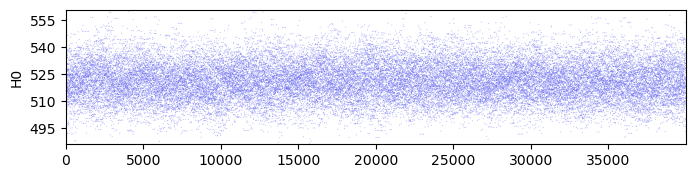

In [8]:
# plot history - should look like noise

samples = sampler.get_chain(flat=True)
chain = Chain.from_emcee(sampler, ['H0'], "an emcee chain", discard=200, thin=2, color="indigo")
consumer = ChainConsumer().add_chain(chain)

fig = consumer.plotter.plot_walks(plot_weights=False);


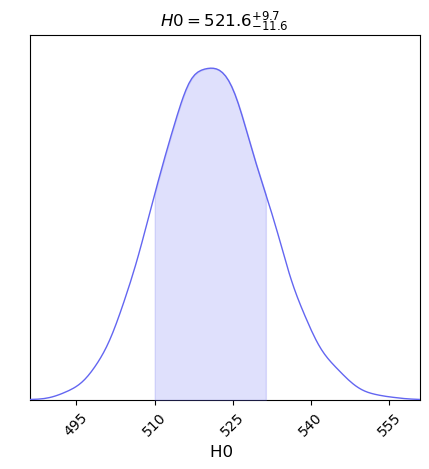

In [9]:
# plot posterior histogram - so far only one variable
fig = consumer.plotter.plot();

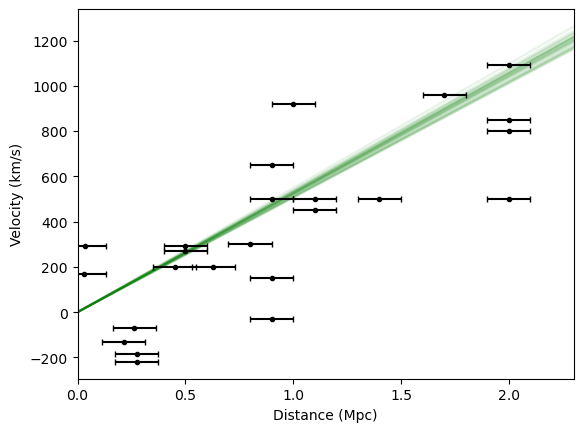

In [10]:
# plot posterior predictive model

inds = np.random.choice(np.arange(samples.shape[0]), 50)
ds = np.linspace(0, 2.3, 100)

for ind in inds:
    H0 = samples[ind,0]

    v_model = H0*ds
    plt.plot(ds, v_model, 'g-', alpha=0.05)

plt.errorbar(d, v,  xerr=d_err, fmt='.', capsize=2,color='k')
plt.xlim(0, ds.max())

plt.xlabel('Distance (Mpc)')
plt.ylabel('Velocity (km/s)');

## Now let's do the Pantheon dataset!

This is a large curated catalogue of modern supernova cosmology data. 

We'll only look in the local universe, where we don't have to solve the full FRW equations.

In [11]:
# load Pantheon Plus dataset

ddir = '../data/'
fname = 'Pantheon.dat'

data = Table.read(ddir+fname, format='ascii')

In [12]:
# read in the Pantheon Plus data
z = data['zCMB']
z_err = data['zCMBERR']
mb = data['MU_SH0ES'] # distance modulus
mb_err = data['MU_SH0ES_ERR_DIAG']

cut = (z > 0.02) & (z < 0.06) & (z_err < 0.005)
z = z[cut]
z_err = z_err[cut]
mb = mb[cut]
mb_err = mb_err[cut]

# distance
d = 10**((mb-25)/5) # Mpc
d_err = d * np.log(10) * mb_err / 5


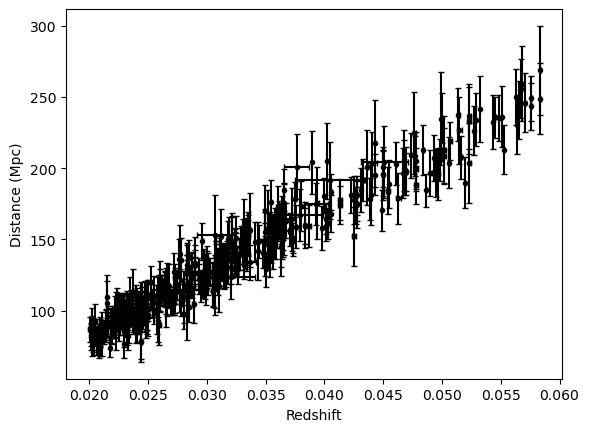

In [13]:
# plot Pantheon Plus data

plt.errorbar(z, d, yerr=d_err, xerr=z_err, fmt='.', capsize=2,color='k')
zs = np.linspace(0, 0.0602, 100)
# Hubble's law
# H0 = 75 km/s/Mpc
# z to velocity
c = 299792.458 # km/s
# Relativistic doppler shift
vs = c * (zs / (1 + zs))
plt.xlim(0.018,0.0602)
plt.xlabel('Redshift')
plt.ylabel('Distance (Mpc)');


In [14]:
def lnprior(H0):
    if 0 < H0 < 200:
        return 0.0
    return -np.inf

def model(H0,intercept,z):
    # now we are including an intercept, ie y = mx + b
    v = c * (z / (1 + z))
    return v/H0 + intercept

def lnlike(H0, intercept, z, d, d_err):
    return -0.5 * np.sum((d-model(H0,intercept,z))**2 / d_err**2)

def lnprob(theta, z, d, d_err):
    H0, intercept = theta
    lp = lnprior(H0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(H0,intercept, z, d, d_err)

In [15]:
# sample with emcee
ndim, nwalkers = 2, 100 # notice we have 2 params 
pos = np.array([68,0]) + 1e-4 * np.random.randn(100, 2)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(z, d, d_err))
burnin = sampler.run_mcmc(pos, 500, progress=True)
sampler.reset()
sampler.run_mcmc(burnin, 1000, progress=True);

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 186.32it/s]


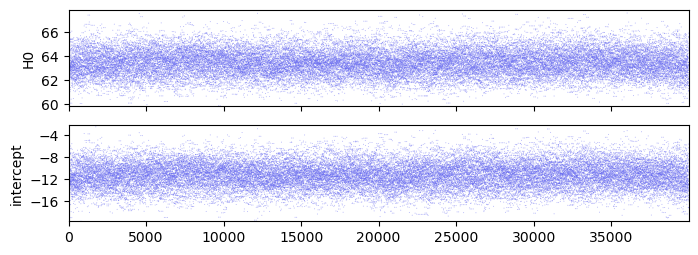

In [16]:
# chainconsumer

samples = sampler.get_chain(flat=True)
chain = Chain.from_emcee(sampler, ['H0','intercept'], "an emcee chain", discard=200, thin=2, color="indigo")
consumer = ChainConsumer().add_chain(chain)

fig = consumer.plotter.plot_walks(plot_weights=False);



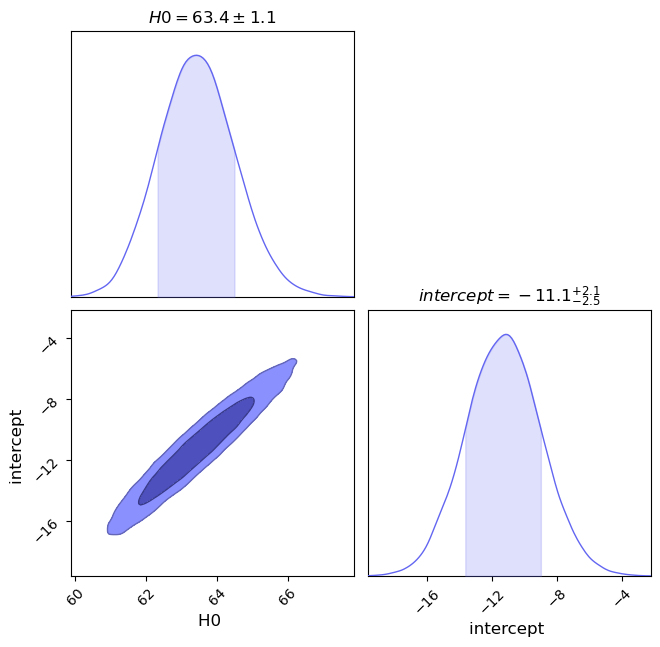

In [17]:
# this is a corner plot, illustrating covariance
fig = consumer.plotter.plot();

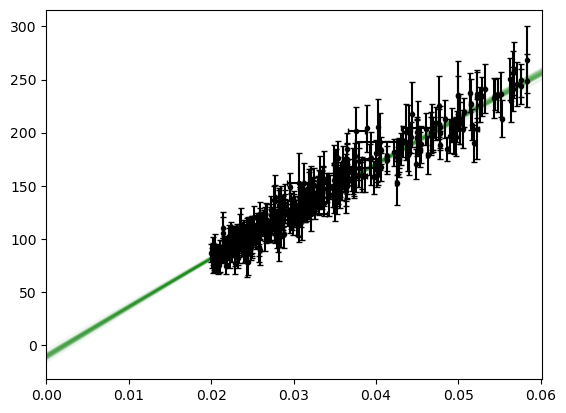

In [18]:
# plot posterior predictive model

# choose values

inds = np.random.choice(np.arange(samples.shape[0]), 50)
zs = np.linspace(0, 0.061, 100)

for ind in inds:
    H0 = samples[ind,0]
    intercept = samples[ind,1]

    d_model = model(H0, intercept, zs)
    plt.plot(zs, d_model, 'g-', alpha=0.05)

plt.errorbar(z, d, yerr=d_err, xerr=z_err, fmt='.', capsize=2,color='k')
plt.xlim(0.0,0.0602);



## Higher dimensional models - covariance

In [19]:
def lnprior(H0):
    if 0 < H0 < 200:
        return 0.0
    return -np.inf

def model(H0,quadratic,intercept,z):
    v = c * (z / (1 + z))
    return v/H0 + intercept + v**2 * quadratic

def lnlike(H0, quadratic, intercept, z, d, d_err):
    return -0.5 * np.sum((d-model(H0,quadratic,intercept,z))**2 / d_err**2)

def lnprob(theta, z, d, d_err):
    H0, quadratic, intercept = theta
    lp = lnprior(H0)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(H0,quadratic,intercept, z, d, d_err)

In [20]:
# sample with emcee
ndim, nwalkers = 3, 100
pos = np.array([68,0,0]) + 1e-4 * np.random.randn(100, 3)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(z, d, d_err))
burnin = sampler.run_mcmc(pos, 500, progress=True)
sampler.reset()
sampler.run_mcmc(burnin, 1000, progress=True);

100%|██████████████████████████████████████| 1000/1000 [00:06<00:00, 145.25it/s]


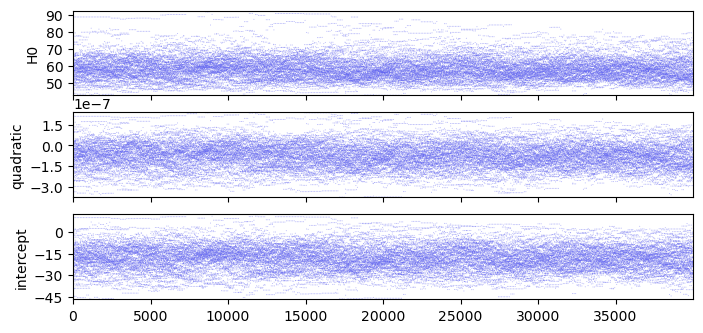

In [21]:
# chainconsumer

samples = sampler.get_chain(flat=True)
chain = Chain.from_emcee(sampler, ['H0','quadratic','intercept'], "an emcee chain", discard=200, thin=2, color="indigo")
consumer = ChainConsumer().add_chain(chain)
fig = consumer.plotter.plot_walks(plot_weights=False);


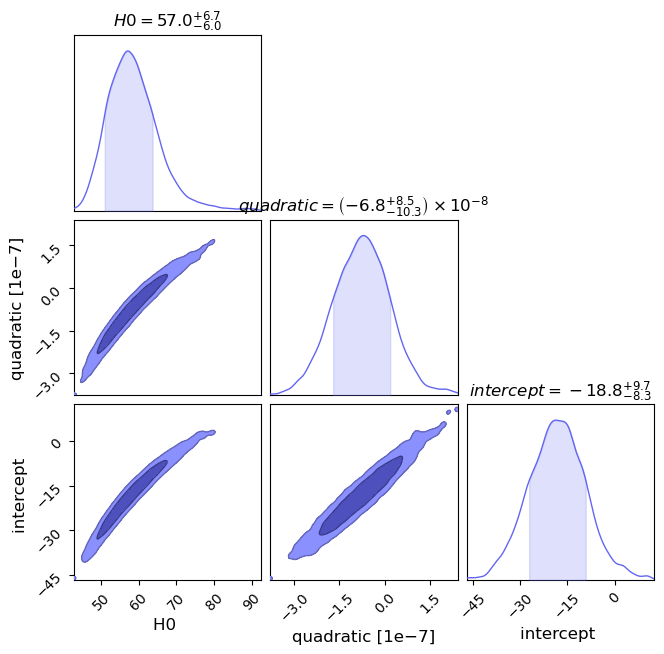

In [22]:
# we now have a higher dimensional corner plot
fig = consumer.plotter.plot(figsize=(7.0,7.0));

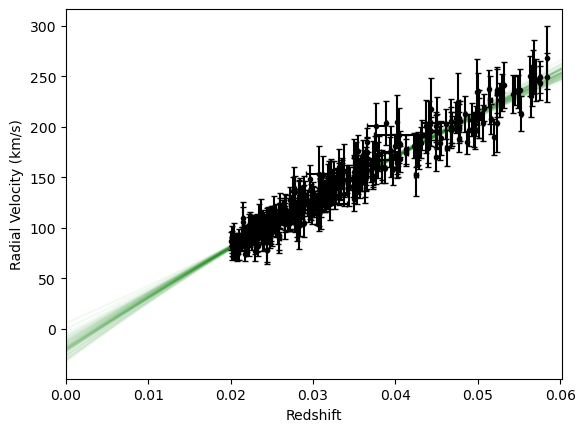

In [24]:
# plot posterior predictive model

inds = np.random.choice(np.arange(samples.shape[0]), 50)
zs = np.linspace(0, 0.061, 100)

for ind in inds:
    H0 = samples[ind,0]
    quadratic = samples[ind,1]
    intercept = samples[ind,2]

    d_model = model(H0, quadratic, intercept, zs)
    plt.plot(zs, d_model, 'g-', alpha=0.05)

plt.errorbar(z, d, yerr=d_err, xerr=z_err, fmt='.', capsize=2,color='k')
plt.xlim(0.0,0.0602);

plt.xlabel('Redshift')
plt.ylabel('Radial Velocity (km/s)');